In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

sys.path.append("../../src")
from explainer import Archipelago
from application_utils.image_utils import *

cnet_path = "../../downloads/pretrained_covid_net/"
sys.path.append(cnet_path)
from data2 import process_image_file

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
explanation_outline_thickness=2

## Get Model

In [3]:
testfolder = "."
weightspath = cnet_path + "models/COVIDNet-CXR3-B"
metaname = "model.meta"
ckptname = "model-1014"

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
tf.get_default_graph()
saver = tf.train.import_meta_graph(os.path.join(weightspath, metaname))
saver.restore(sess, os.path.join(weightspath, ckptname))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ../../downloads/pretrained_covid_net/models/COVIDNet-CXR3-B/model-1014


In [4]:
class COVIDNetWrapper:
    def __init__(self, sess, logit_tensor, image_tensor):
        self.sess = sess
        self.logit_tensor = logit_tensor
        self.image_tensor = image_tensor
        
    def __call__(self, x):
        pred = self.sess.run(self.logit_tensor, feed_dict={self.image_tensor: x})
        return pred

In [5]:
image_tensor = graph.get_tensor_by_name("input_1:0")
logit_tensor = graph.get_tensor_by_name("norm_dense_1/MatMul:0")

model_wrapper = COVIDNetWrapper(sess, logit_tensor, image_tensor)

## Get Data

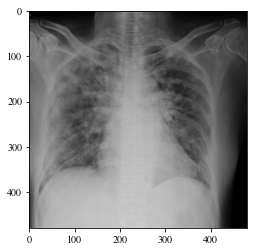

In [6]:
class_meaning = {0:'normal', 1:'pneumonia', 2:'COVID-19'}

input_size = 480
x = process_image_file(os.path.join(testfolder, "covid_xray.jpg"), 0.08, input_size)
image = x.astype('float32') / 255.0

plt.imshow(image)
plt.show()

## Get Classification

In [7]:
class_idx = model_wrapper(np.expand_dims(image, 0)).argmax(axis=1)[0]
print("classification:", class_meaning[class_idx])

classification: COVID-19


## Explain Classification

In [8]:
segments = quickshift(image, kernel_size=6, max_dist=300, ratio=0.2)
print("num segments", len(np.unique(segments)))
baseline = np.zeros_like(image)
xf = ImageXformer(image, baseline, segments)

apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20, verbose=False)

num segments 77


In [9]:
explanation = apgo.explain(top_k=5)

### Show Explanation

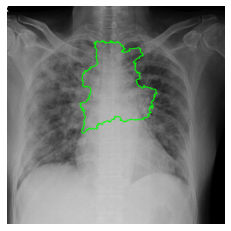

In [10]:
exp, _ = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)

plt.imshow(exp)
plt.axis("off")
# plt.savefig("results/img.png", bbox_inches = "tight")
plt.show()